c:\Users\Eric\Documents\Python\grocery_fcst
                            OLS Regression Results                            
Dep. Variable:          grocery_sales   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.384e+04
Date:                Sat, 26 Jul 2025   Prob (F-statistic):          3.70e-305
Time:                        17:01:50   Log-Likelihood:                -2063.8
No. Observations:                 258   AIC:                             4140.
Df Residuals:                     252   BIC:                             4161.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

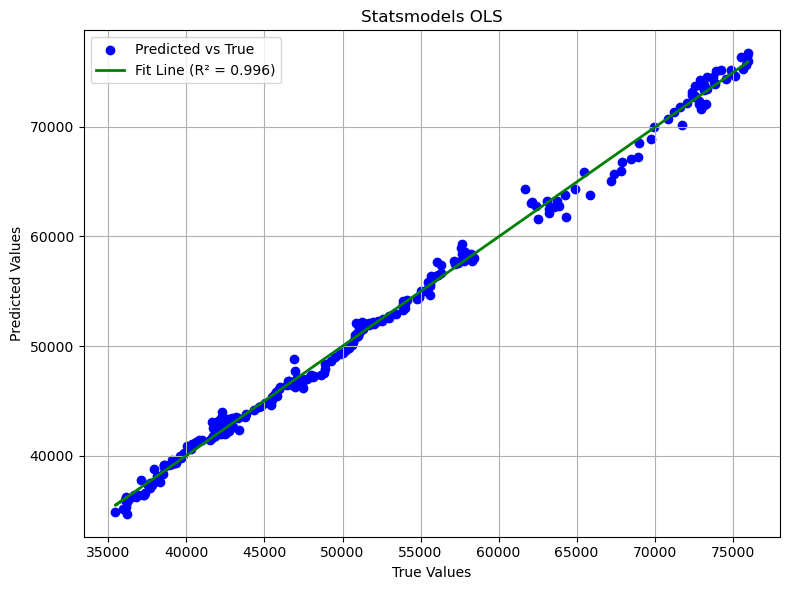

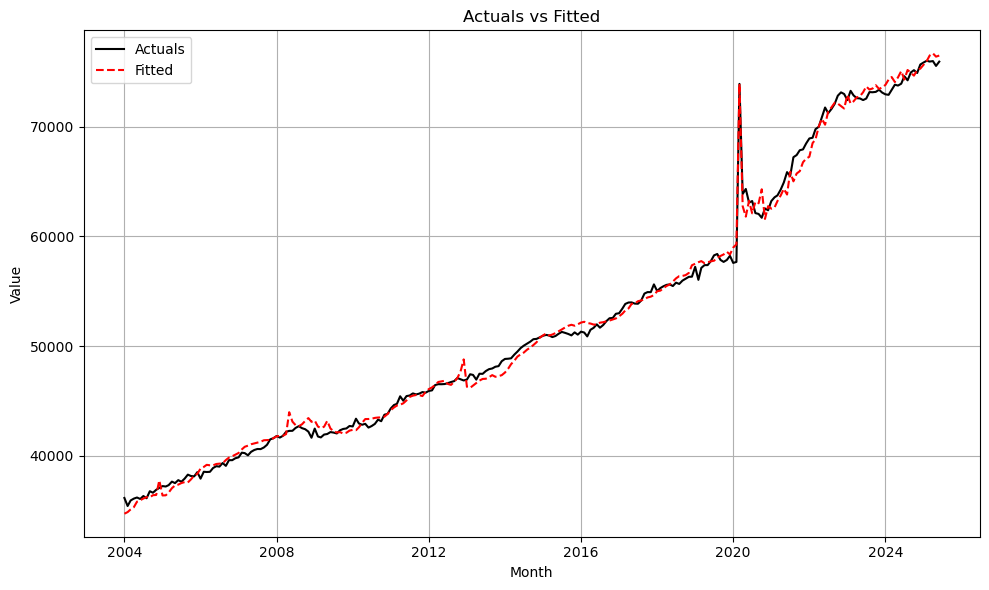

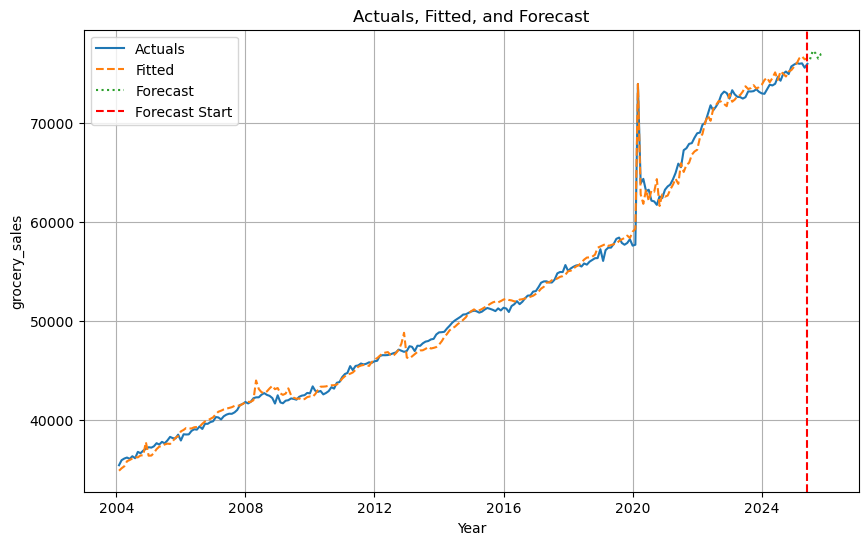

                            OLS Regression Results                            
Dep. Variable:          grocery_sales   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.180e+04
Date:                Sat, 26 Jul 2025   Prob (F-statistic):               0.00
Time:                        17:01:50   Log-Likelihood:                -1972.7
No. Observations:                 257   AIC:                             3959.
Df Residuals:                     250   BIC:                             3984.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.142e+04    996

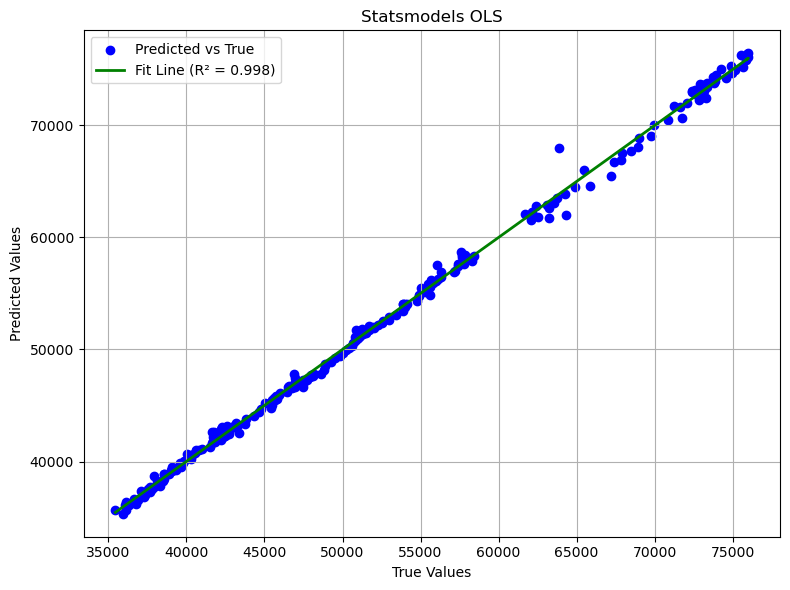

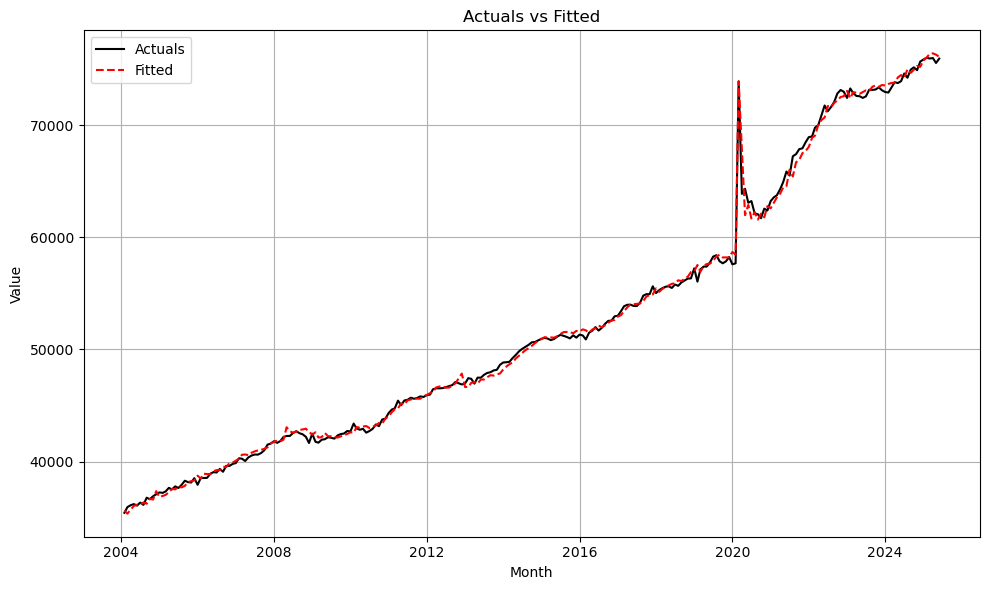

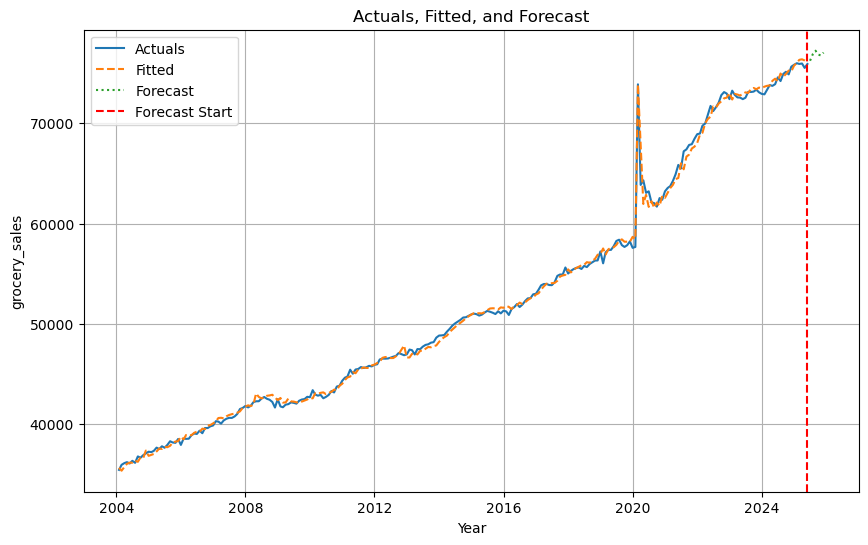

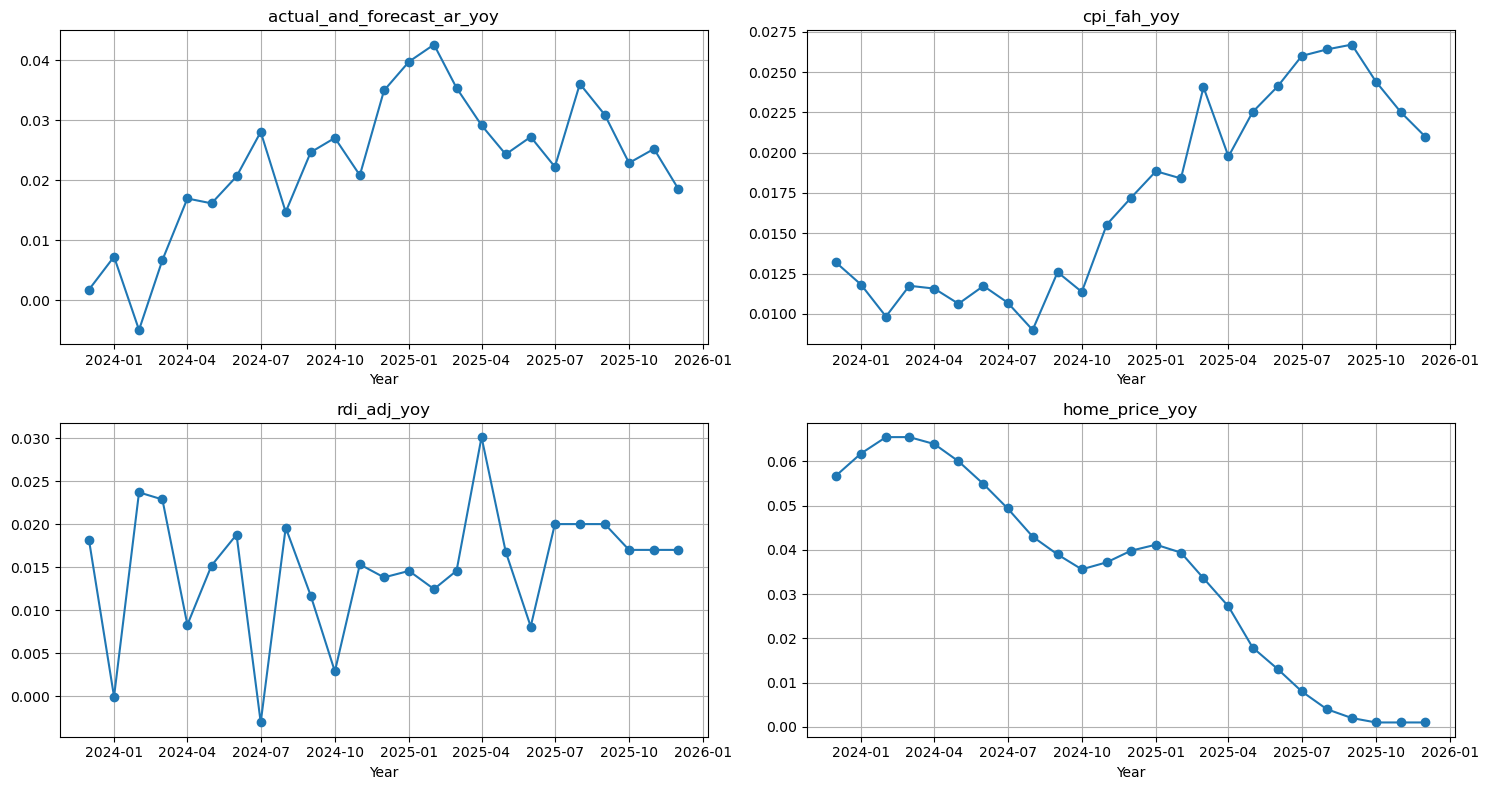

ADF Statistic: -5.7437
p-value: 0.0000
Residuals are stationary (reject null hypothesis). ✅
Mean: 2.59
5th Percentile: 2.15
95th Percentile: 3.03


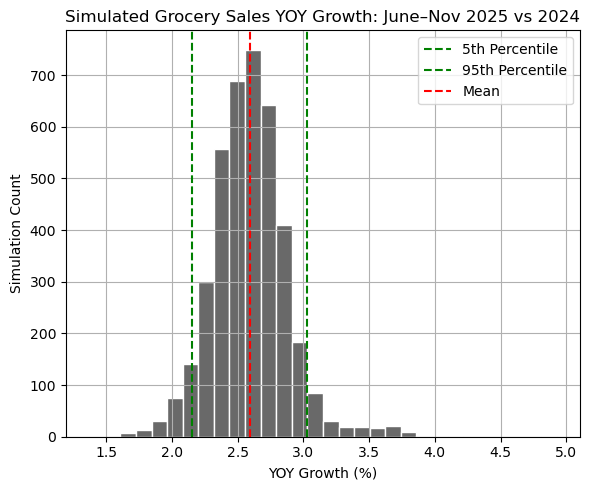

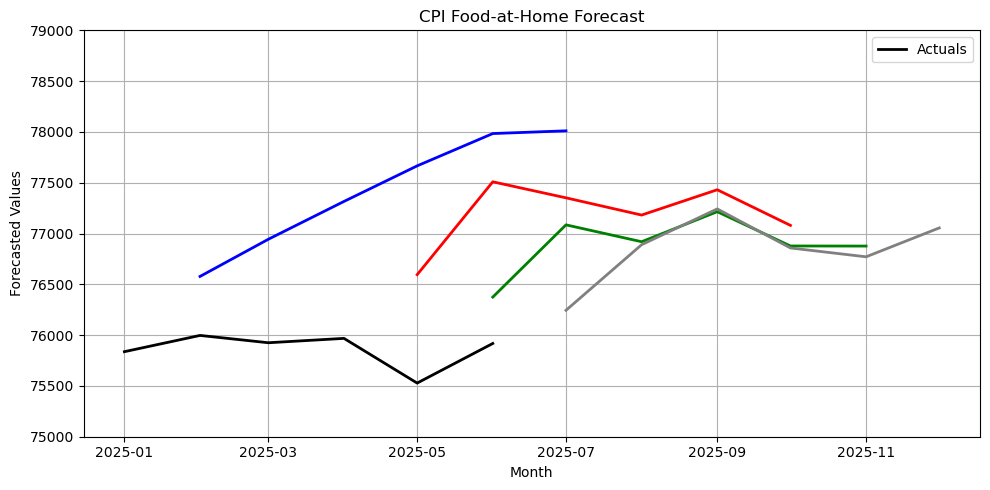

In [9]:
# helps fix a bug between pymc3 and numpy
import os
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as at
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
if os.getcwd().endswith("notebooks"):
    os.chdir("..")  # Go up one level to grocery_fcst

print(os.getcwd()) 

# ----------------------------------------------------------------------
# STAGE 1 - Clean Data
# ----------------------------------------------------------------------

# Confirm no missing values

from controls.grocery_control import *
from forecast_engine.data_processing import ingest_data

df = ingest_data(
    econ_data="c:/Users/eric/Documents/Python/econ_dashboard/output/fetch_fred_data.csv", 
    rdi_data="c:/Users/eric/Documents/Python/grocery_fcst/data/RDI Analysis.xlsx")

df_train = df.loc[start_date_training:end_date_training]
df_train = df_train[ind + [dep]]
df_train.isnull().sum()

df_train = df_train.ffill()
df_train.isnull().sum()

# ----------------------------------------------------------------------
# STAGE 2 - Train Model
# ----------------------------------------------------------------------

from forecast_engine.ols_engine import fit_ols_statsmodels, evaluate_model
from forecast_engine.plotting import plot_true_vs_predicted, plot_actual_vs_fitted_series

# Define date range
X_train = df_train.loc[start_date_training : end_date_training, ind]
y_train = df_train.loc[start_date_training : end_date_training, dep]

# ✅ Statsmodels OLS and merge onto df_train
model, y_fitted = fit_ols_statsmodels(X_train, y_train)
df_train['y_fitted'] = y_fitted
df_train['residuals'] = y_fitted - df_train['grocery_sales']

# Evaluate Model
print(model.summary())
evaluate_model(y_train, y_fitted, model_name="Statsmodels OLS")

# Visuals
plot_true_vs_predicted(y_train, y_fitted, title="Statsmodels OLS")
plot_actual_vs_fitted_series(y_train, y_fitted)

# ----------------------------------------------------------------------
# STAGE 3 - Build Forward File
# ----------------------------------------------------------------------

from forecast_engine.data_processing import forward_values

forward_values_df = forward_values(
    csv_file = "C:/Users/eric/Documents/Python/grocery_fcst/data/forward_values.csv",
    df_train=df_train)

# Step 5: concat forward values with df_trian to make df_full
df_full = pd.concat([df_train, forward_values_df], axis=0)

# ----------------------------------------------------------------------
# STAGE 4 - Forward Forecast
# ----------------------------------------------------------------------

from forecast_engine.ols_engine import predict_ols_statsmodels
from forecast_engine import plot_actual_vs_fitted_vs_forecast

# --- Forecast and merge onto df -------------------------------------------------------------
y_forecast = predict_ols_statsmodels(forward_values_df, model)
df_full['y_forecast'] = y_forecast 

# Combine columns and prep data for AR forecast
df_full['actual_and_forecast'] = df_full[dep].combine_first(df_full['y_forecast'])
df_full['fitted_and_forecast'] = df_full['y_fitted'].combine_first(df_full['y_forecast'])
df_full['grocery_sales_lag1'] = df_full['actual_and_forecast'].shift(1)
df_full = df_full[df_full['grocery_sales_lag1'].notna()]

# chart for fitted and forecast
plot_actual_vs_fitted_vs_forecast(df_combined=df_full, dep='grocery_sales', fitted_col = 'y_fitted', forecast_col='y_forecast')


# ----------------------------------------------------------------------
# STAGE 5 - Train AR
# ----------------------------------------------------------------------
from forecast_engine.ols_engine import fit_ols_statsmodels, evaluate_model
from forecast_engine.plotting import plot_true_vs_predicted, plot_actual_vs_fitted_series
from controls.grocery_control import *

X_train_ar = df_full.loc[start_date_training : end_date_training, ind + ['grocery_sales_lag1']]
y_train_ar = df_full.loc[start_date_training : end_date_training, dep]

df_train_ar = df_full.loc[start_date_training : end_date_training]
df_train_ar = df_train_ar[ind + ['grocery_sales']]

# --- Train OLS Models ----------------------------------------------------
model_ar, y_fitted_ar = fit_ols_statsmodels(X_train_ar, y_train_ar)

# Step 4: Convert forecast series into a df for joining
fitted_df = y_fitted_ar.reset_index() # by resetting index, it turns series into df
fitted_df.columns = ['month', 'y_fitted_ar']
fitted_df = fitted_df.set_index('month')
df_full = df_full.join(fitted_df, how='left')
df_full['residuals_ar'] = df_full['y_fitted_ar'] - df_full['grocery_sales']

# Evaluate Model
print(model_ar.summary())
evaluate_model(y_train_ar, y_fitted_ar, model_name="Statsmodels OLS")

# Calculate the standardized coeficients
coefs = model_ar.params.drop('const', errors='ignore')

# Get standard deviations of X and y
std_X = X_train_ar[coefs.index].std()
std_y = y_train_ar.std()

# Calculate standardized coefficients
standardized_coefs = coefs * std_X / std_y

print(f'Standarized Coefficients: {standardized_coefs}')

# Visuals
plot_true_vs_predicted(y_train_ar, y_fitted_ar, title="Statsmodels OLS")
plot_actual_vs_fitted_series(y_train_ar, y_fitted_ar)

# ----------------------------------------------------------------------
# STAGE 6 - Forecast AR
# ----------------------------------------------------------------------

# --- Forecast and merge onto df -------------------------------------------------------------
from controls.grocery_control import start_date_forecast, end_date_forecast
from forecast_engine.ols_engine import predict_ols_statsmodels

# Step 1: Filter forecast rows
forward_values_df_ar = df_full.loc[start_date_forecast : end_date_forecast]

# Step 2: Select the features used in the autoregressive model
# Assuming `ind` is your list of independent variables
X_forward_ar = forward_values_df_ar[ind + ['grocery_sales_lag1']]

# Step 3: Forecast forward
y_forecast_ar = predict_ols_statsmodels(X_forward_ar, model_ar)

# Step 4: Convert forecast series into a df for joining
forecast_df = y_forecast_ar.reset_index() # by resetting index, it turns series into df
forecast_df.columns = ['month', 'y_forecast_ar']
forecast_df = forecast_df.set_index('month')
df_full = df_full.join(forecast_df, how='left')

plot_actual_vs_fitted_vs_forecast(df_combined=df_full, dep=dep, fitted_col='y_fitted_ar', forecast_col='y_forecast_ar')

df_full.to_csv('C:/Users/eric/Documents/Python/grocery_fcst/output/df_full.csv')

# ----------------------------------------------------------------------
# STAGE 7 - YOY Calcalations and charts
# ----------------------------------------------------------------------

# Combine actual and forecast columns
df_full['actual_and_forecast_ar'] = df_full['grocery_sales'].combine_first(df_full['y_forecast_ar'])
df_full['fitted_and_forecast_ar'] = df_full['y_fitted_ar'].combine_first(df_full['y_forecast_ar'])

# Ensure the index is datetime and sorted
df_full = df_full.sort_index()

df_full['actual_and_forecast_ar_ly'] = df_full['actual_and_forecast_ar'].shift(12)
df_full['fitted_and_forecast_ar_ly'] = df_full['fitted_and_forecast_ar'].shift(12)
df_full['grocery_sales_ly'] = df_full['grocery_sales'].shift(12)
df_full['cpi_fah_ly'] = df_full['cpi_fah'].shift(12)
df_full['rdi_adj_ly'] = df_full['rdi_adj'].shift(12)
df_full['home_price_ly'] = df_full['home_price'].shift(12)

# Calculate YOY % change
col_list = ['actual_and_forecast_ar', 'fitted_and_forecast_ar', 'grocery_sales', 'cpi_fah', 'rdi_adj', 'home_price']

for col in col_list:
    df_full[f'{col}_yoy'] = df_full[col]/df_full[f'{col}_ly'] - 1
    
from forecast_engine.plotting import plot_input_variables, lineplot_list

yoy_cols = ['actual_and_forecast_ar_yoy', 'cpi_fah_yoy', 'rdi_adj_yoy', 'home_price_yoy']
plot_input_variables(df=df_full, input_vars=yoy_cols, years=2)

# ----------------------------------------------------------------------
# STAGE 8 - Bootstrap Simulations and Charts
# ----------------------------------------------------------------------

from controls.grocery_control import start_date_forecast
from forecast_engine.plotting import plot_aggregate_forecast_distribution_yoy

from forecast_engine.bootstrap_engine import (
    check_residual_stationarity,
    simulate_bootstrap_forecasts,
    aggregate_forecast_distribution
)

# clean residuals
residuals_ar_series = df_full['residuals_ar'].dropna()

# Test residuals for stationarity
is_stationary = check_residual_stationarity(residuals=residuals_ar_series, alpha=0.05)

# Run the forecast - this returns a (4000,6) array.  4000 is similations and 6 is the number of months. 
# #It applies the residuals to estimate 4000 values for each month
forecast_bs = simulate_bootstrap_forecasts(X_future= X_forward_ar, model_or_beta=model_ar, residuals=residuals_ar_series, n_simulations=4000, random_state=43)

# Aggregate the n periods in the rest of year summation - this return (4000,)  It sums across the six columns to get a six month sales value
agg_forecast_bs = aggregate_forecast_distribution(forecast_matrix = forecast_bs, agg_func=np.sum)
agg_forecast_bs_df = pd.DataFrame(agg_forecast_bs)

# Define 6-month forecast window so we can calculate the six month sales LY
end_forecast_6mo = start_date_forecast + pd.DateOffset(months=5)

# Calculate LY aggregated values.  This code uses the start and end dates to capture the same months LY
df_yoy_base = df_full.loc[start_date_forecast : end_forecast_6mo, 'actual_and_forecast_ar_ly'].sum() # this is the LY value for six months of sales
agg_forecast_bs_df['y_fcst_yoy'] = (agg_forecast_bs_df['y_fcst_total'] - df_yoy_base) / df_yoy_base * 100 # this create a YOY estimate for each simulation

# this is for lines in the chart
summary_yoy = {
    'mean': agg_forecast_bs_df['y_fcst_yoy'].mean(),
    'p5':   agg_forecast_bs_df['y_fcst_yoy'].quantile(0.05),
    'p95':  agg_forecast_bs_df['y_fcst_yoy'].quantile(0.95),
}

# print out results
print(f"Mean: {summary_yoy['mean']:.2f}")
print(f"5th Percentile: {summary_yoy['p5']:.2f}")
print(f"95th Percentile: {summary_yoy['p95']:.2f}")

# plot the agg residual bootstrap distribution
plot_aggregate_forecast_distribution_yoy(df=agg_forecast_bs_df, yoy_col='y_fcst_yoy', summary_yoy=summary_yoy)

# ----------------------------------------------------------------------
# STAGE 9 - Rolling forecast chart
# ----------------------------------------------------------------------

from controls.grocery_control import *
from forecast_engine.plotting import plot_final_chart

# import data
df_fcst_chart = pd.read_csv("c:/Users/eric/Documents/Python/grocery_fcst/data/grocery_forecast_chart.csv")
df_fcst_chart = df_fcst_chart.set_index('month')

# Define the index for the new forecast
start = pd.to_datetime(start_date_forecast)
end = pd.to_datetime(end_date_forecast)

# Normalize both indexes to remove time component
new_fcst_mo = pd.date_range(start, end, freq='MS').normalize()
df.index = pd.to_datetime(df.index).normalize()
df_fcst_chart.index = pd.to_datetime(df_fcst_chart.index).normalize()

# remove current forecast column if it exists
if forecast_month in df_fcst_chart.columns:
    df_fcst_chart = df_fcst_chart.drop(columns=forecast_month)
    
# Build the new fcst table
new_fcst = pd.DataFrame(index=new_fcst_mo)
new_fcst = pd.merge(new_fcst, df_full['y_forecast_ar'], left_index=True, right_index=True, how='inner')
new_fcst = new_fcst.rename(columns={'y_forecast_ar': forecast_month} )

# Merge forecast table with new forecast
rolling_forecast_df = pd.merge(df_fcst_chart, new_fcst, left_index=True, right_index=True, how='outer')
col = rolling_forecast_df.pop("Actuals")
rolling_forecast_df.insert(0, "Actuals", col)

plot_final_chart(rolling_forecast_df, color_map, y_bounds=(75000, 79000))

# this saves the data in the chart above
rolling_forecast_df.to_csv(f'c:/Users/eric/Documents/Python/grocery_fcst/data/grocery_forecast_chart_{forecast_month}.csv', index=True, index_label="month") # create a backup that is not overwritten
rolling_forecast_df.to_csv('c:/Users/eric/Documents/Python/grocery_fcst/data/grocery_forecast_chart.csv', index=True, index_label="month") # the main file to build and maintain


